In [1]:
from Crypto.Util.number import inverse, bytes_to_long, long_to_bytes
from Crypto.Util.Padding import pad, unpad
import secrets, random

# Prerequisites

- Stream ciphers intro (MUST)
    - https://www.youtube.com/watch?v=9MfeDP0fNDY - if you're still lazy
- Semantic security
- One time pad
- Intuition: 
    - https://www.youtube.com/watch?v=fEWigU1dcp8

# Theory PRG

## Definitions

Let $l, L, l<L$ denote the number of bits for some strings

**Problem**:
- producing purelt $L$-bit strings might be ineficient
- Example: In the OTP case, the key must be the same size as the message => we need big keys

**Idea**:
- We want a way to produce $L$-bit strings using $l$-bit seeds using and efficient algorithm (Ex: polynomial time)

**Definition**  
Let $\mathcal{S} = \{0,1\}^l = $ the seed space, $\mathcal{R} = \{0,1\}^L=$ output space  
Let $G$ be a function (efficient deterministic algorithm) with
- $G: \{0,1\}^l \longrightarrow \{0,1\}^L$
    - G expands $l$-bit strings  to $L$-bit strings
- No efficient algorithm $A$(statistical test) can distinguish $G(s)$ with $s \in \{0,1\}^l$ from a truly random string $r \in \{0,1\}^L$ with better than neglijable advantage
    - $Pr[A(G(s))=1]−Pr[A(r)=1]|  < \epsilon$

**Statistical tests**

Let $G:K \longrightarrow \{0,1\}^n$ and define **Advantage** as:
$\text{Adv}(A, G) = |Pr[A(G(k)) = 1] - Pr[A(k) = 1]| \in [0, 1]$
- If $\text{Adv} \rightarrow 1$ => $A$ can distinguish from random
- If $\text{Adv} \rightarrow 0$ => $A$ can't distinguish from random

**Example**: 
Suppose 
- $msb(G(k)) = 1$ for $2/3$ of $k \in K$
- $A(x) = 1 \iff msb(x) = 1$

 Then
- $\text{Adv}(A,G) = |Pr[A(G(k)) = 1] - Pr[A(k) = 1]| = |2/3 - 1/2| = 1/6$

**Definition**

A PRG is secure if for all effiecient statistical tests $A$ the $\text{Adv}(A, G)$ is neglijable

## Construction

**Parallel construction**

Let $G$ be a PRG over $(\mathcal{S}, \mathcal{R})$. We construct a PRG $G'$ by concatenating $G$ applied to $n$ seeds
- $G'(s_1, .. s_n) = G(s_1) || ... || G(s_n)$
- If $G$ is secure then $G'$ is secure

**Sequential construction - Blum-Micali**  

Let $G$ be a PRG over $(\mathcal{S}, \mathcal{R} \times \mathcal{S})$. We construct a PRG $G'$ defined over $(\mathcal{S}, \mathcal{R}^n \times \mathcal{S})$
```
G(s) = 
s_0 = s
for i = 1  to  n 
        (r_i, s_i) = G(s_{i-1}) 
return  (r_1, ... r_n, s_n)
```F (k, ·) should — for all practical purposes — “look like” a random function
from X to Y. To make this idea more precise, let us first introduce 
- If $G$ is secure then G' is also secure
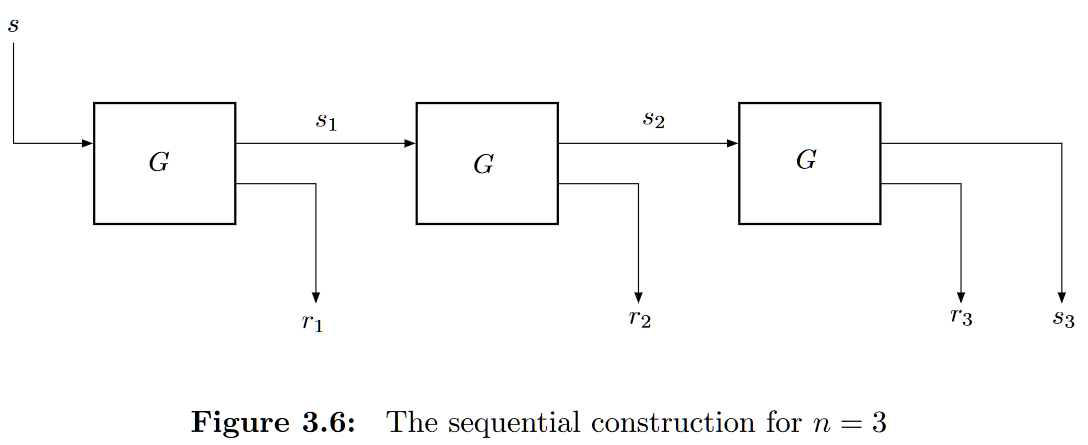
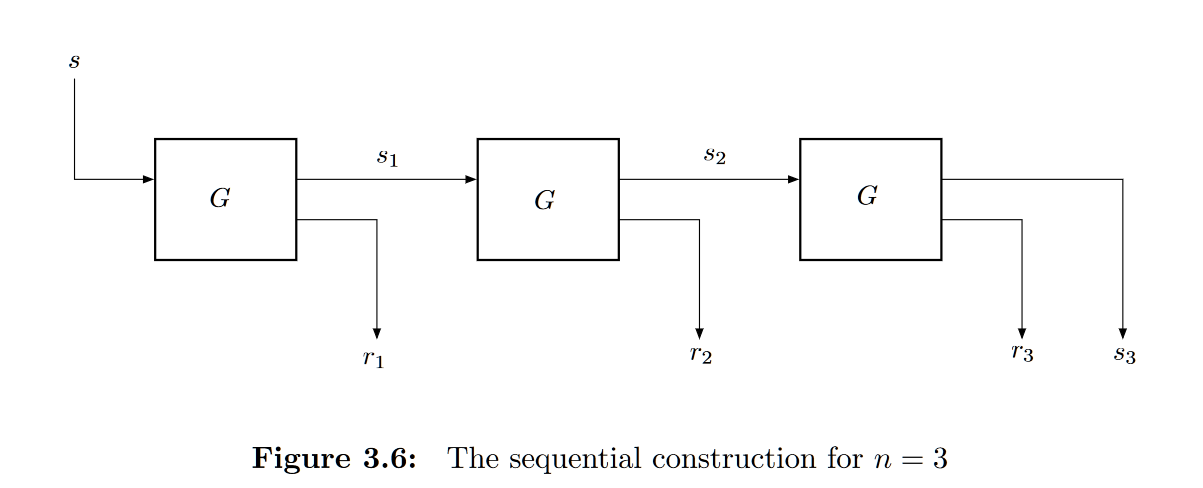

## Unpredictability

*Intuition*: Given the first $i$ bits of $G$'s output it is hard to predict the next bit ($i+1$) with a probability $> 1/2$

A PRG $G$ is unpredictable if any efficient adversary $A$ has a neglijable advantage

**Theorem**
> If the genrator $G$ is secure => a PRG based on it it's unpredictable

**Theorem**
> An unpredictable PRG is secure (Then the G is secure)

# Salsa and ChaCha stream ciphers  + Code

- https://en.wikipedia.org/wiki/Salsa20
- https://cr.yp.to/chacha/chacha-20080120.pdf - paper
- https://asecuritysite.com/encryption/salsa20
- https://cr.yp.to/chacha.html

**Structure**
- Padding function $\text{pad}(s, j, 0)$ to form a 512b block
    - s = 128/256b seed
    - j = 64b counter
    - 0 = 64b nonce (set to 0 for now)
- Public permutation $\pi:\{0, 1\}^{512} \longrightarrow \{0, 1\}^{512}$

**Algorithm**
- input: seed $s \in \{0,1\}^{256}$
- for $j = 0$ to $L - 1$
    - $h_j = \text{pad}(s, j, 0) \in \{0, 1\}^{512}$
    - $r_j = \pi(h_j) \oplus h_j$
- output: $(r_0, \dots , r_{L-1})$

**Note**:
- Highly paralelizable
-  XOR on line 3 is a slightly more complicated operation:  the 512-bit operands $h_j$ and $π(h_j)$ are split into 16 wordseach 32-bits long and then added word-wise mod $2^{32}$

ChaCha craziness: 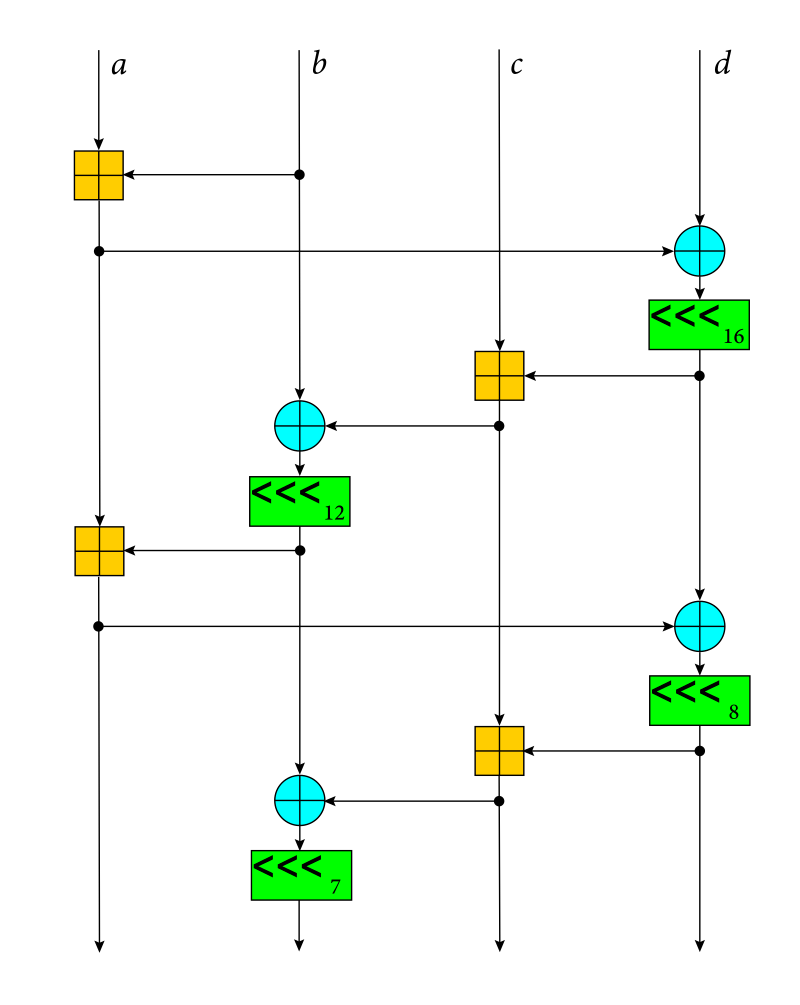

In [2]:
class ChaCha:
    def __init__(self, pos = bytes(8)):
        self.rounds = 20
        #self.mod = pow(2, 32) # we do this with a mask 
        self.mask = pow(2, 32) - 1 #ffffffff
        self.constant = b'expand 32-byte k'
        self.pos = pos
    
    def start(self, key = bytes(32), nonce = bytes(8)):
        
        #set the key and nonce
        self.nonce = nonce
        self.key = key
        
        #get the initial state
        s_init = self.pad(self.key, self.nonce)
        s = s_init.copy()
        
        #do the rounds
        for i in range(self.rounds):
            s = self.cha_round(s, i);
        
        # This addition makes the round uninvertible
        s_fin = [(s_init[i] + s[i]) & self.mask for i in range(len(s))]
        
        self.pos = long_to_bytes(bytes_to_long(self.pos) + 1, 8) #increment the pos after 1 generation
        
        return s_fin
            
    def rotl(self, x, b):
        '''rotate left x with b bytes'''
        return ((x << b) & self.mask) | (x >> (32 - b))
    
    def pad(self, key = bytes(32), nonce = bytes(8)):
        '''pads the initial state'''
        c = [bytes_to_long(bytes(reversed(self.constant[i:i+4]))) for i in range(0, 16, 4)] #reversed for little endian?
        k = [bytes_to_long(bytes(reversed(key[i:i+4]))) for i in range(0, 32, 4)]
        n = [bytes_to_long(bytes(reversed(nonce[i:i+4]))) for i in range(0, 8, 4)]
        p = [bytes_to_long(bytes(reversed(self.pos[i:i+4]))) for i in range(0, 8, 4)]
        
        s_init = c + k + p + n
        #print('initial state:' , s_init)
        return s_init
    
    
    def cha_round(self, s, i):
        '''does the i'th cha round'''
        #odd round
        if i & 1 == 1: #this check can be skiped if we do rounds in pairs
            s[0], s[4], s[8], s[12] = self.qr(s[0], s[4], s[8], s[12]) #1st column
            s[1], s[5], s[9], s[13] = self.qr(s[1], s[5], s[9], s[13]) #2st column
            s[2], s[6], s[10], s[14] = self.qr(s[2], s[6], s[10], s[14]) #3st column
            s[3], s[7], s[11], s[15] = self.qr(s[3], s[7], s[11], s[15]) #4st column
        #even round
        else:
            s[0], s[5], s[10], s[15] = self.qr(s[0], s[5], s[10], s[15]) #1st diagonal
            s[1], s[6], s[11], s[12] = self.qr(s[1], s[6], s[11], s[12]) #2st diagonal
            s[2], s[7], s[8], s[13] = self.qr(s[2], s[7], s[8], s[13]) #3st diagonal
            s[3], s[4], s[9], s[14] = self.qr(s[3], s[4], s[9], s[14]) #4st diagonal
        return s
        
        
    def qr(self, a, b, c, d):
        a = (a + b) & self.mask
        d= d ^ a 
        d = self.rotl(d, 16)
        
        c = (c + d) & self.mask
        b = b ^ c
        b = self.rotl(b, 12)
        
        a = (a + b) & self.mask
        d ^= a
        d = self.rotl(d, 8)
        
        c = (c + d) & self.mask
        b = b ^ c
        b = self.rotl(b, 7)
        
        return a, b, c, d
        

In [3]:
hex((pow(2, 32) - 1))

'0xffffffff'

In [4]:
key = b'this very secret key has 32bytes'
nonce = secrets.token_bytes(8) # or set this to 0

In [5]:
chacha = ChaCha()
chacha.pad(key = key, nonce = nonce)

[1634760805,
 857760878,
 2036477234,
 1797285236,
 1936287860,
 1919252000,
 1702043769,
 1952805475,
 2036689696,
 1935763488,
 1647457056,
 1936028793,
 0,
 0,
 1829556743,
 3871994548]

In [8]:
key, nonce

(b'this very secret key has 32bytes', b'\x07\xd2\x0cm\xb4\xf2\xc9\xe6')

In [6]:
e = chacha.start(key = key, nonce = nonce)
e

[1139498044,
 4174770291,
 2946286892,
 1948150382,
 2541928431,
 519052022,
 1918612576,
 1291256139,
 3811076367,
 1800498885,
 3284698787,
 1889162493,
 2569098760,
 1649579750,
 1093798813,
 3901408402]

In [13]:
len(e)

16

In [14]:
sum([el.bit_length() for el in e])

499